In [1]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import requests
import os
import csv
import keras
import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy 

Using TensorFlow backend.


Pulls data from websites and stores them in csv files

In [2]:
def update_data():
    positive_cases_csv_URL = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
    req = requests.get(positive_cases_csv_URL)
    URL_content = req.content
    positive_cases_file = open("positive_cases.csv", "wb")
    positive_cases_file.write(URL_content)
    positive_cases_file.close()

This is purely for the sources of data that include data outside the UK as having international data would mean too much to parse through

In [3]:
def filter_data(filename):
    uk = list()
    with open(filename, 'r') as readFile:
        reader = csv.reader(readFile)
        for row in reader:
            if row[0] == "GBR" or row[0] == "iso_code":
                uk.append(row)
    
    with open(filename, 'w') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerows(uk)  


Counts the number of days since the earliest data entry

In [4]:
def numberofdays(date_in_question):
    start_date = date(2020, 1, 31)
    dateq = date_in_question.split("-")
    cdate = date(int(dateq[0]), int(dateq[1]), int(dateq[2]))
    return (cdate - start_date).days

This will normalise all the data in a dataframe

In [5]:
def normalise_dataframe(df):
    for i in range(1, len(df.columns)):
        maxi = max(df.iloc[:,i])
        mini = min(df.iloc[:,i])
        for j in range(len(df.iloc[:,0])):
            df.iloc[j, i] = (df.iloc[j, i] - mini)/(maxi-mini)

This will only take columns in the data frame with no NaNs

In [6]:
def no_NaNs(df):
    data = []
    for column in df.columns:
        temp = [float(i) for i in df[column]]
        if np.isnan(np.sum(np.array(temp))):
            df.drop([column], inplace=True, axis=1)

This will only take columns that don't have a single repeating entry

In [7]:
def no_repeat(df):
    data = []
    for column in df.columns:
        if df[column].nunique() == 1:
            df.drop([column], inplace=True, axis=1)

This will create the input array for the Neural Network

In [8]:
def create_features(df, window_size, forecast):
    features = []
    labels = []
    i = window_size;
    while i < len(df.iloc[:, 0]) - forecast-1:
        window = df.iloc[i - window_size: i, 1:]
        window = np.array(window)
        window = window.flatten()
        labels.append(df.iloc[i + forecast, 0])
        features.append(window)
        i += 1
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

In [9]:
update_data() 

In [10]:
filter_data("positive_cases.csv")

Grabs the current working directory where the csv files are stored

In [11]:
working_dir = os.getcwd()

Reads the csv files into their respective dataframes

In [12]:
pos_cases_df = pd.read_csv(os.path.join(working_dir, "positive_cases.csv"))
pos_cases_df.drop(pos_cases_df.iloc[:, 0:3], inplace = True, axis=1)
dates = pos_cases_df["date"]
pos_cases_df.drop(["date"], inplace = True, axis=1)
pos_cases_df.drop(["tests_units"], inplace = True, axis=1)

In [13]:
no_NaNs(pos_cases_df)

In [14]:
no_repeat(pos_cases_df)

In [75]:
print((pos_cases_df.head()).to_markdown())

|    |   total_cases |   new_cases |   total_cases_per_million |   new_cases_per_million |   stringency_index |
|---:|--------------:|------------:|--------------------------:|------------------------:|-------------------:|
|  0 |             2 |           2 |                     0.029 |                   0.029 |               8.33 |
|  1 |             2 |           0 |                     0.029 |                   0     |               8.33 |
|  2 |             2 |           0 |                     0.029 |                   0     |              11.11 |
|  3 |             8 |           6 |                     0.118 |                   0.088 |              11.11 |
|  4 |             8 |           0 |                     0.118 |                   0     |              11.11 |


Code just adds a column to the dataframe that counts the number of days since the earliest data entry

In [15]:
daysSince = []
for i in range(len(pos_cases_df)):
    daysSince.append(i)
pos_cases_df["daysSince"] = daysSince

In [78]:
print((pos_cases_df.head()).to_markdown())

|    |   total_cases |   new_cases |   total_cases_per_million |   new_cases_per_million |   stringency_index |   daysSince |
|---:|--------------:|------------:|--------------------------:|------------------------:|-------------------:|------------:|
|  0 |             2 |           2 |                     0.029 |                   0.029 |               8.33 |           0 |
|  1 |             2 |           0 |                     0.029 |                   0     |               8.33 |           1 |
|  2 |             2 |           0 |                     0.029 |                   0     |              11.11 |           2 |
|  3 |             8 |           6 |                     0.118 |                   0.088 |              11.11 |           3 |
|  4 |             8 |           0 |                     0.118 |                   0     |              11.11 |           4 |


Here I make the feature and label matrices with a 7 day window and a 1 day forecast

In [16]:
window_size = 7
forecast = 1
features1, labels1 = create_features(pos_cases_df, window_size, forecast)

Splitting the feature and label matrices into training and testing by 8:2. I will split the training further down into 8:2 again for validation.

In [17]:
training_features1, testing_features1 = np.split(features1, [int(0.8*len(features1))])
training_labels1, testing_labels1 = np.split(labels1, [int(0.8*len(labels1))])

In [18]:
input_shape = training_features1.shape[1]

In [19]:
NN_model = Sequential()
# Input layer
NN_model.add(Dense(128, input_dim=input_shape, kernel_initializer="normal", activation="relu"))
# Hidden Layers
NN_model.add(Dense(256, kernel_initializer="normal", activation="relu"))
NN_model.add(Dense(256, kernel_initializer="normal", activation="relu"))
NN_model.add(Dense(256, kernel_initializer="normal", activation="relu"))
# Output layer 
NN_model.add(Dense(1, kernel_initializer="normal", activation="linear"))

NN_model.compile(loss="mean_absolute_error", optimizer="adam", metrics=["accuracy"])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3712      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 168,577
Trainable params: 168,577
Non-trainable params: 0
_________________________________________________________________


In [20]:
history1 = NN_model.fit(training_features1, training_labels1, epochs=500, validation_split=0.2)

Train on 261 samples, validate on 66 samples
Epoch 1/500
261/261 [==============================] - 0s 888us/step - loss: 250428.5345 - accuracy: 0.0000e+00 - val_loss: 1553346.3485 - val_accuracy: 0.0000e+00
Epoch 2/500
261/261 [==============================] - 0s 120us/step - loss: 229867.9078 - accuracy: 0.0000e+00 - val_loss: 1138850.6780 - val_accuracy: 0.0000e+00
Epoch 3/500
261/261 [==============================] - 0s 60us/step - loss: 119646.5588 - accuracy: 0.0000e+00 - val_loss: 887179.9811 - val_accuracy: 0.0000e+00
Epoch 4/500
261/261 [==============================] - 0s 120us/step - loss: 96479.3670 - accuracy: 0.0000e+00 - val_loss: 177836.5076 - val_accuracy: 0.0000e+00
Epoch 5/500
261/261 [==============================] - 0s 120us/step - loss: 58001.1678 - accuracy: 0.0000e+00 - val_loss: 120781.4773 - val_accuracy: 0.0000e+00
Epoch 6/500
261/261 [==============================] - 0s 85us/step - loss: 31806.1906 - accuracy: 0.0000e+00 - val_loss: 42505.5975 - val_ac

261/261 [==============================] - 0s 120us/step - loss: 7813.2213 - accuracy: 0.0077 - val_loss: 22604.2652 - val_accuracy: 0.0000e+00
Epoch 53/500
261/261 [==============================] - 0s 120us/step - loss: 3996.2738 - accuracy: 0.0038 - val_loss: 26641.2803 - val_accuracy: 0.0000e+00
Epoch 54/500
261/261 [==============================] - 0s 85us/step - loss: 6110.6123 - accuracy: 0.0115 - val_loss: 18711.2756 - val_accuracy: 0.0000e+00
Epoch 55/500
261/261 [==============================] - 0s 120us/step - loss: 8015.5329 - accuracy: 0.0000e+00 - val_loss: 35394.9669 - val_accuracy: 0.0000e+00
Epoch 56/500
261/261 [==============================] - 0s 60us/step - loss: 4705.8509 - accuracy: 0.0115 - val_loss: 33219.2178 - val_accuracy: 0.0000e+00
Epoch 57/500
261/261 [==============================] - 0s 145us/step - loss: 6078.4127 - accuracy: 0.0077 - val_loss: 40121.3902 - val_accuracy: 0.0000e+00
Epoch 58/500
261/261 [==============================] - 0s 60us/step 

261/261 [==============================] - 0s 120us/step - loss: 2098.8510 - accuracy: 0.0077 - val_loss: 12704.2907 - val_accuracy: 0.0000e+00
Epoch 105/500
261/261 [==============================] - 0s 60us/step - loss: 2501.9112 - accuracy: 0.0115 - val_loss: 16845.4299 - val_accuracy: 0.0000e+00
Epoch 106/500
261/261 [==============================] - 0s 145us/step - loss: 1485.6267 - accuracy: 0.0115 - val_loss: 13127.3523 - val_accuracy: 0.0000e+00
Epoch 107/500
261/261 [==============================] - 0s 60us/step - loss: 1392.3556 - accuracy: 0.0192 - val_loss: 9047.4669 - val_accuracy: 0.0000e+00
Epoch 108/500
261/261 [==============================] - 0s 120us/step - loss: 2665.5764 - accuracy: 0.0192 - val_loss: 8344.8977 - val_accuracy: 0.0000e+00
Epoch 109/500
261/261 [==============================] - 0s 60us/step - loss: 2297.0923 - accuracy: 0.0038 - val_loss: 7758.2377 - val_accuracy: 0.0000e+00
Epoch 110/500
261/261 [==============================] - 0s 85us/step - 

261/261 [==============================] - 0s 85us/step - loss: 6205.9133 - accuracy: 0.0192 - val_loss: 33810.7481 - val_accuracy: 0.0000e+00
Epoch 157/500
261/261 [==============================] - 0s 120us/step - loss: 5214.2052 - accuracy: 0.0115 - val_loss: 42720.8182 - val_accuracy: 0.0000e+00
Epoch 158/500
261/261 [==============================] - 0s 120us/step - loss: 3114.6331 - accuracy: 0.0038 - val_loss: 21365.3996 - val_accuracy: 0.0000e+00
Epoch 159/500
261/261 [==============================] - 0s 85us/step - loss: 2464.7165 - accuracy: 0.0192 - val_loss: 35942.8826 - val_accuracy: 0.0000e+00
Epoch 160/500
261/261 [==============================] - 0s 60us/step - loss: 2581.8911 - accuracy: 0.0153 - val_loss: 13032.7178 - val_accuracy: 0.0000e+00
Epoch 161/500
261/261 [==============================] - 0s 60us/step - loss: 1723.1325 - accuracy: 0.0077 - val_loss: 6538.0966 - val_accuracy: 0.0000e+00
Epoch 162/500
261/261 [==============================] - 0s 120us/step 

261/261 [==============================] - 0s 89us/step - loss: 5586.8667 - accuracy: 0.0153 - val_loss: 34371.5795 - val_accuracy: 0.0000e+00
Epoch 209/500
261/261 [==============================] - 0s 60us/step - loss: 4866.4736 - accuracy: 0.0077 - val_loss: 23815.6080 - val_accuracy: 0.0000e+00
Epoch 210/500
261/261 [==============================] - 0s 120us/step - loss: 2750.5042 - accuracy: 0.0115 - val_loss: 52573.1780 - val_accuracy: 0.0000e+00
Epoch 211/500
261/261 [==============================] - 0s 120us/step - loss: 6807.1546 - accuracy: 0.0115 - val_loss: 74135.3996 - val_accuracy: 0.0000e+00
Epoch 212/500
261/261 [==============================] - 0s 59us/step - loss: 7064.3384 - accuracy: 0.0153 - val_loss: 67880.8939 - val_accuracy: 0.0000e+00
Epoch 213/500
261/261 [==============================] - 0s 60us/step - loss: 5404.9390 - accuracy: 0.0153 - val_loss: 9399.8826 - val_accuracy: 0.0000e+00
Epoch 214/500
261/261 [==============================] - 0s 120us/step 

261/261 [==============================] - 0s 96us/step - loss: 4042.3549 - accuracy: 0.0230 - val_loss: 13554.2036 - val_accuracy: 0.0000e+00
Epoch 261/500
261/261 [==============================] - 0s 96us/step - loss: 2272.7866 - accuracy: 0.0307 - val_loss: 28986.1581 - val_accuracy: 0.0000e+00
Epoch 262/500
261/261 [==============================] - 0s 100us/step - loss: 2192.4445 - accuracy: 0.0345 - val_loss: 12710.9792 - val_accuracy: 0.0000e+00
Epoch 263/500
261/261 [==============================] - 0s 96us/step - loss: 2507.2079 - accuracy: 0.0268 - val_loss: 7218.1960 - val_accuracy: 0.0000e+00
Epoch 264/500
261/261 [==============================] - 0s 92us/step - loss: 1659.8917 - accuracy: 0.0230 - val_loss: 8961.8703 - val_accuracy: 0.0000e+00
Epoch 265/500
261/261 [==============================] - 0s 96us/step - loss: 2053.0285 - accuracy: 0.0115 - val_loss: 35604.5597 - val_accuracy: 0.0000e+00
Epoch 266/500
261/261 [==============================] - 0s 103us/step - 

261/261 [==============================] - 0s 145us/step - loss: 1897.5013 - accuracy: 0.0230 - val_loss: 7782.3475 - val_accuracy: 0.0000e+00
Epoch 313/500
261/261 [==============================] - 0s 60us/step - loss: 2441.0759 - accuracy: 0.0268 - val_loss: 10667.8835 - val_accuracy: 0.0000e+00
Epoch 314/500
261/261 [==============================] - 0s 120us/step - loss: 2452.5288 - accuracy: 0.0153 - val_loss: 15166.6525 - val_accuracy: 0.0000e+00
Epoch 315/500
261/261 [==============================] - 0s 120us/step - loss: 4875.7519 - accuracy: 0.0077 - val_loss: 63249.9886 - val_accuracy: 0.0000e+00
Epoch 316/500
261/261 [==============================] - 0s 85us/step - loss: 6611.6276 - accuracy: 0.0307 - val_loss: 17705.0663 - val_accuracy: 0.0000e+00
Epoch 317/500
261/261 [==============================] - 0s 60us/step - loss: 1596.8021 - accuracy: 0.0038 - val_loss: 21280.7235 - val_accuracy: 0.0000e+00
Epoch 318/500
261/261 [==============================] - 0s 60us/step 

261/261 [==============================] - 0s 60us/step - loss: 4093.7128 - accuracy: 0.0268 - val_loss: 26818.4858 - val_accuracy: 0.0000e+00
Epoch 365/500
261/261 [==============================] - 0s 145us/step - loss: 2690.5056 - accuracy: 0.0192 - val_loss: 17902.3494 - val_accuracy: 0.0000e+00
Epoch 366/500
261/261 [==============================] - 0s 60us/step - loss: 2599.7880 - accuracy: 0.0153 - val_loss: 36759.6487 - val_accuracy: 0.0000e+00
Epoch 367/500
261/261 [==============================] - 0s 120us/step - loss: 3635.3106 - accuracy: 0.0192 - val_loss: 9046.1174 - val_accuracy: 0.0000e+00
Epoch 368/500
261/261 [==============================] - 0s 120us/step - loss: 3090.7737 - accuracy: 0.0153 - val_loss: 6961.7680 - val_accuracy: 0.0000e+00
Epoch 369/500
261/261 [==============================] - 0s 85us/step - loss: 2418.3758 - accuracy: 0.0230 - val_loss: 11831.5559 - val_accuracy: 0.0000e+00
Epoch 370/500
261/261 [==============================] - 0s 60us/step -

261/261 [==============================] - 0s 96us/step - loss: 12535.2261 - accuracy: 0.0038 - val_loss: 89824.8068 - val_accuracy: 0.0000e+00
Epoch 417/500
261/261 [==============================] - 0s 92us/step - loss: 6482.2158 - accuracy: 0.0115 - val_loss: 30282.5019 - val_accuracy: 0.0000e+00
Epoch 418/500
261/261 [==============================] - 0s 96us/step - loss: 6233.6863 - accuracy: 0.0153 - val_loss: 47861.7292 - val_accuracy: 0.0000e+00
Epoch 419/500
261/261 [==============================] - 0s 96us/step - loss: 3418.0284 - accuracy: 0.0268 - val_loss: 8482.3968 - val_accuracy: 0.0000e+00
Epoch 420/500
261/261 [==============================] - 0s 92us/step - loss: 2387.0843 - accuracy: 0.0077 - val_loss: 6663.8911 - val_accuracy: 0.0000e+00
Epoch 421/500
261/261 [==============================] - 0s 92us/step - loss: 4483.3617 - accuracy: 0.0230 - val_loss: 39259.3220 - val_accuracy: 0.0000e+00
Epoch 422/500
261/261 [==============================] - 0s 100us/step - 

261/261 [==============================] - 0s 85us/step - loss: 3868.5937 - accuracy: 0.0268 - val_loss: 12693.7121 - val_accuracy: 0.0000e+00
Epoch 469/500
261/261 [==============================] - 0s 120us/step - loss: 2246.9058 - accuracy: 0.0115 - val_loss: 6950.0616 - val_accuracy: 0.0000e+00
Epoch 470/500
261/261 [==============================] - 0s 60us/step - loss: 1750.8737 - accuracy: 0.0230 - val_loss: 18155.2235 - val_accuracy: 0.0000e+00
Epoch 471/500
261/261 [==============================] - 0s 60us/step - loss: 1858.4267 - accuracy: 0.0307 - val_loss: 28544.6373 - val_accuracy: 0.0000e+00
Epoch 472/500
261/261 [==============================] - 0s 85us/step - loss: 3705.1320 - accuracy: 0.0268 - val_loss: 31003.5634 - val_accuracy: 0.0000e+00
Epoch 473/500
261/261 [==============================] - 0s 153us/step - loss: 3824.1467 - accuracy: 0.0307 - val_loss: 7922.5881 - val_accuracy: 0.0000e+00
Epoch 474/500
261/261 [==============================] - 0s 96us/step - 

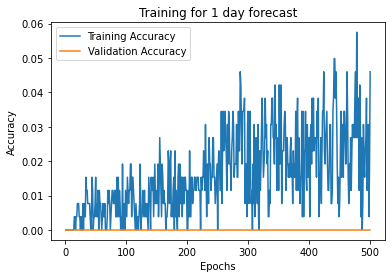

In [22]:
epochs = range(1, len(history1.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history1.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training for 1 day forecast")
plt.legend()
plt.show()

In [23]:
x = [i for i in range(int(testing_features1[0,-1]+1), int(testing_features1[-1,-1]+2))]
y = testing_labels1
x_pred = testing_features1
y_pred = NN_model.predict(x_pred)
err1 = np.abs(y - y_pred)
acc1 = np.ones(len(y)) - np.divide(err1, y)
acc_bar1 = np.mean(acc1)
rms1 = np.sqrt(np.mean((err1)**2))
print("Average accuracy:", acc_bar1)
print("RMS:", rms1)

Average accuracy: 0.8485905486581791
RMS: 705828.519894445


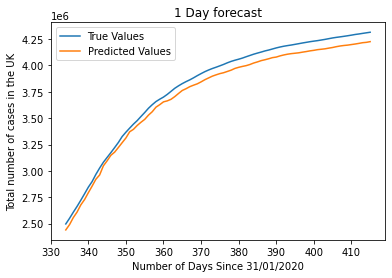

In [25]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Number of Days Since 31/01/2020")
plt.ylabel("Total number of cases in the UK")
plt.title("1 Day forecast")
plt.legend()
plt.show()

Here I make a new feature and label matrix with a 7 day window and a 2 day forecast

In [70]:
window_size = 7
forecast = 2
features2, labels2 = create_features(pos_cases_df, window_size, forecast)

I split the matrices down into training and testing using a 8:2 splitting

In [71]:
training_features2, testing_features2 = np.split(features2, [int(0.8*len(features2))])
training_labels2, testing_labels2 = np.split(labels2, [int(0.8*len(labels2))])

The model has to be trained again with this new data

In [28]:
history2 = NN_model.fit(training_features2, training_labels2, epochs=500, validation_split=0.2)

Train on 260 samples, validate on 66 samples
Epoch 1/500
260/260 [==============================] - 0s 120us/step - loss: 5066.3646 - accuracy: 0.0154 - val_loss: 45546.6894 - val_accuracy: 0.0000e+00
Epoch 2/500
260/260 [==============================] - 0s 60us/step - loss: 5443.8853 - accuracy: 0.0192 - val_loss: 12006.7936 - val_accuracy: 0.0000e+00
Epoch 3/500
260/260 [==============================] - 0s 145us/step - loss: 3873.0934 - accuracy: 0.0000e+00 - val_loss: 11262.7339 - val_accuracy: 0.0000e+00
Epoch 4/500
260/260 [==============================] - 0s 120us/step - loss: 2106.3950 - accuracy: 0.0154 - val_loss: 13798.9441 - val_accuracy: 0.0000e+00
Epoch 5/500
260/260 [==============================] - 0s 120us/step - loss: 2039.6794 - accuracy: 0.0154 - val_loss: 33536.4299 - val_accuracy: 0.0000e+00
Epoch 6/500
260/260 [==============================] - 0s 85us/step - loss: 4163.0932 - accuracy: 0.0231 - val_loss: 29529.9214 - val_accuracy: 0.0000e+00
Epoch 7/500
260/2

Epoch 53/500
260/260 [==============================] - 0s 120us/step - loss: 3478.1217 - accuracy: 0.0000e+00 - val_loss: 28060.5303 - val_accuracy: 0.0000e+00
Epoch 54/500
260/260 [==============================] - 0s 145us/step - loss: 2992.9264 - accuracy: 0.0077 - val_loss: 16816.0161 - val_accuracy: 0.0000e+00
Epoch 55/500
260/260 [==============================] - 0s 60us/step - loss: 2334.4806 - accuracy: 0.0192 - val_loss: 23202.7585 - val_accuracy: 0.0000e+00
Epoch 56/500
260/260 [==============================] - 0s 120us/step - loss: 2599.8942 - accuracy: 0.0231 - val_loss: 22025.7642 - val_accuracy: 0.0000e+00
Epoch 57/500
260/260 [==============================] - 0s 120us/step - loss: 2716.0602 - accuracy: 0.0154 - val_loss: 10985.8390 - val_accuracy: 0.0000e+00
Epoch 58/500
260/260 [==============================] - 0s 60us/step - loss: 2328.2506 - accuracy: 0.0269 - val_loss: 10144.2159 - val_accuracy: 0.0000e+00
Epoch 59/500
260/260 [==============================] - 

260/260 [==============================] - 0s 96us/step - loss: 2997.1498 - accuracy: 0.0154 - val_loss: 21805.6326 - val_accuracy: 0.0000e+00
Epoch 106/500
260/260 [==============================] - 0s 96us/step - loss: 2902.4423 - accuracy: 0.0346 - val_loss: 12774.0114 - val_accuracy: 0.0000e+00
Epoch 107/500
260/260 [==============================] - 0s 104us/step - loss: 2134.1411 - accuracy: 0.0269 - val_loss: 10855.8864 - val_accuracy: 0.0000e+00
Epoch 108/500
260/260 [==============================] - 0s 96us/step - loss: 2601.5984 - accuracy: 0.0308 - val_loss: 35442.1269 - val_accuracy: 0.0000e+00
Epoch 109/500
260/260 [==============================] - 0s 100us/step - loss: 4325.4105 - accuracy: 0.0038 - val_loss: 35197.8153 - val_accuracy: 0.0000e+00
Epoch 110/500
260/260 [==============================] - 0s 104us/step - loss: 5511.3551 - accuracy: 0.0385 - val_loss: 31629.6638 - val_accuracy: 0.0000e+00
Epoch 111/500
260/260 [==============================] - 0s 92us/step

Epoch 157/500
260/260 [==============================] - 0s 96us/step - loss: 4682.4372 - accuracy: 0.0308 - val_loss: 10833.2557 - val_accuracy: 0.0000e+00
Epoch 158/500
260/260 [==============================] - 0s 104us/step - loss: 3458.3691 - accuracy: 0.0154 - val_loss: 12204.8873 - val_accuracy: 0.0000e+00
Epoch 159/500
260/260 [==============================] - 0s 100us/step - loss: 4206.3222 - accuracy: 0.0346 - val_loss: 35286.2216 - val_accuracy: 0.0000e+00
Epoch 160/500
260/260 [==============================] - 0s 96us/step - loss: 3718.4998 - accuracy: 0.0385 - val_loss: 30111.9110 - val_accuracy: 0.0000e+00
Epoch 161/500
260/260 [==============================] - 0s 88us/step - loss: 1981.8932 - accuracy: 0.0192 - val_loss: 12371.4981 - val_accuracy: 0.0000e+00
Epoch 162/500
260/260 [==============================] - 0s 88us/step - loss: 2047.2835 - accuracy: 0.0154 - val_loss: 18166.3617 - val_accuracy: 0.0000e+00
Epoch 163/500
260/260 [==============================] -

260/260 [==============================] - 0s 60us/step - loss: 2344.3729 - accuracy: 0.0269 - val_loss: 12333.1458 - val_accuracy: 0.0000e+00
Epoch 210/500
260/260 [==============================] - 0s 120us/step - loss: 2186.5467 - accuracy: 0.0231 - val_loss: 9403.4981 - val_accuracy: 0.0000e+00
Epoch 211/500
260/260 [==============================] - 0s 120us/step - loss: 2212.5402 - accuracy: 0.0269 - val_loss: 17864.4640 - val_accuracy: 0.0000e+00
Epoch 212/500
260/260 [==============================] - 0s 85us/step - loss: 2855.3741 - accuracy: 0.0192 - val_loss: 11563.8731 - val_accuracy: 0.0000e+00
Epoch 213/500
260/260 [==============================] - 0s 120us/step - loss: 4082.3096 - accuracy: 0.0115 - val_loss: 16245.4659 - val_accuracy: 0.0000e+00
Epoch 214/500
260/260 [==============================] - 0s 60us/step - loss: 3128.8457 - accuracy: 0.0269 - val_loss: 12111.8949 - val_accuracy: 0.0000e+00
Epoch 215/500
260/260 [==============================] - 0s 120us/step

Epoch 261/500
260/260 [==============================] - 0s 92us/step - loss: 1854.1641 - accuracy: 0.0385 - val_loss: 11068.8920 - val_accuracy: 0.0000e+00
Epoch 262/500
260/260 [==============================] - 0s 92us/step - loss: 2274.1344 - accuracy: 0.0423 - val_loss: 12241.7737 - val_accuracy: 0.0000e+00
Epoch 263/500
260/260 [==============================] - 0s 92us/step - loss: 1668.3273 - accuracy: 0.0308 - val_loss: 19215.3608 - val_accuracy: 0.0000e+00
Epoch 264/500
260/260 [==============================] - 0s 70us/step - loss: 1749.6915 - accuracy: 0.0308 - val_loss: 12331.5634 - val_accuracy: 0.0000e+00
Epoch 265/500
260/260 [==============================] - 0s 120us/step - loss: 2764.4911 - accuracy: 0.0231 - val_loss: 26515.7576 - val_accuracy: 0.0000e+00
Epoch 266/500
260/260 [==============================] - 0s 68us/step - loss: 2210.4119 - accuracy: 0.0269 - val_loss: 38619.3939 - val_accuracy: 0.0000e+00
Epoch 267/500
260/260 [==============================] - 

260/260 [==============================] - 0s 92us/step - loss: 3516.6655 - accuracy: 0.0231 - val_loss: 13660.4972 - val_accuracy: 0.0000e+00
Epoch 314/500
260/260 [==============================] - 0s 100us/step - loss: 2105.7273 - accuracy: 0.0000e+00 - val_loss: 26342.0530 - val_accuracy: 0.0000e+00
Epoch 315/500
260/260 [==============================] - 0s 96us/step - loss: 2689.3400 - accuracy: 0.0115 - val_loss: 12292.5152 - val_accuracy: 0.0000e+00
Epoch 316/500
260/260 [==============================] - 0s 92us/step - loss: 3499.9214 - accuracy: 0.0115 - val_loss: 45830.3608 - val_accuracy: 0.0000e+00
Epoch 317/500
260/260 [==============================] - 0s 100us/step - loss: 3977.5698 - accuracy: 0.0308 - val_loss: 35779.6250 - val_accuracy: 0.0000e+00
Epoch 318/500
260/260 [==============================] - 0s 96us/step - loss: 5009.7999 - accuracy: 0.0154 - val_loss: 20098.3920 - val_accuracy: 0.0000e+00
Epoch 319/500
260/260 [==============================] - 0s 96us/s

260/260 [==============================] - 0s 120us/step - loss: 2602.3820 - accuracy: 0.0231 - val_loss: 12395.2405 - val_accuracy: 0.0000e+00
Epoch 366/500
260/260 [==============================] - 0s 120us/step - loss: 3939.5798 - accuracy: 0.0115 - val_loss: 22068.3163 - val_accuracy: 0.0000e+00
Epoch 367/500
260/260 [==============================] - 0s 85us/step - loss: 4895.3771 - accuracy: 0.0231 - val_loss: 21659.5189 - val_accuracy: 0.0000e+00
Epoch 368/500
260/260 [==============================] - 0s 120us/step - loss: 2510.5441 - accuracy: 0.0500 - val_loss: 14222.5862 - val_accuracy: 0.0000e+00
Epoch 369/500
260/260 [==============================] - 0s 60us/step - loss: 1764.8389 - accuracy: 0.0423 - val_loss: 16719.9953 - val_accuracy: 0.0000e+00
Epoch 370/500
260/260 [==============================] - 0s 120us/step - loss: 3258.6409 - accuracy: 0.0115 - val_loss: 16507.4138 - val_accuracy: 0.0000e+00
Epoch 371/500
260/260 [==============================] - 0s 60us/ste

260/260 [==============================] - 0s 120us/step - loss: 2069.4030 - accuracy: 0.0308 - val_loss: 16756.4659 - val_accuracy: 0.0000e+00
Epoch 418/500
260/260 [==============================] - 0s 120us/step - loss: 1946.5091 - accuracy: 0.0462 - val_loss: 15392.9470 - val_accuracy: 0.0000e+00
Epoch 419/500
260/260 [==============================] - 0s 85us/step - loss: 2044.0167 - accuracy: 0.0346 - val_loss: 9976.4384 - val_accuracy: 0.0000e+00
Epoch 420/500
260/260 [==============================] - 0s 120us/step - loss: 2308.7415 - accuracy: 0.0154 - val_loss: 12795.8295 - val_accuracy: 0.0000e+00
Epoch 421/500
260/260 [==============================] - 0s 60us/step - loss: 2283.9772 - accuracy: 0.0077 - val_loss: 15633.5701 - val_accuracy: 0.0000e+00
Epoch 422/500
260/260 [==============================] - 0s 60us/step - loss: 4590.1084 - accuracy: 0.0154 - val_loss: 30090.1155 - val_accuracy: 0.0000e+00
Epoch 423/500
260/260 [==============================] - 0s 85us/step 

260/260 [==============================] - 0s 120us/step - loss: 4682.8652 - accuracy: 0.0231 - val_loss: 19536.9384 - val_accuracy: 0.0000e+00
Epoch 470/500
260/260 [==============================] - 0s 120us/step - loss: 2716.2592 - accuracy: 0.0231 - val_loss: 15412.8267 - val_accuracy: 0.0000e+00
Epoch 471/500
260/260 [==============================] - 0s 60us/step - loss: 3047.6058 - accuracy: 0.0154 - val_loss: 14158.0663 - val_accuracy: 0.0000e+00
Epoch 472/500
260/260 [==============================] - 0s 145us/step - loss: 2243.3909 - accuracy: 0.0462 - val_loss: 16584.9773 - val_accuracy: 0.0000e+00
Epoch 473/500
260/260 [==============================] - 0s 60us/step - loss: 1919.9202 - accuracy: 0.0154 - val_loss: 16781.6127 - val_accuracy: 0.0000e+00
Epoch 474/500
260/260 [==============================] - 0s 120us/step - loss: 4707.7953 - accuracy: 0.0192 - val_loss: 36094.2197 - val_accuracy: 0.0000e+00
Epoch 475/500
260/260 [==============================] - 0s 120us/st

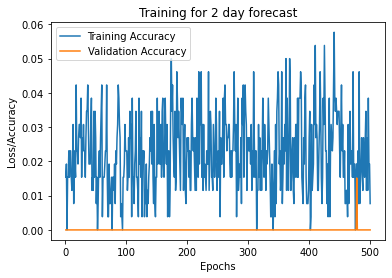

In [53]:
epochs = range(1, len(history2.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history2.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title("Training for 2 day forecast")
plt.legend()
plt.show()

In [30]:
x = [i for i in range(int(testing_features2[0,-1]+1), int(testing_features2[-1,-1]+2))]
y = testing_labels2
x_pred = testing_features2
y_pred = NN_model.predict(x_pred) 
err2 = np.abs(y - y_pred)
acc2 = np.ones(len(y)) - np.divide(err2, y)
acc_bar2 = np.mean(acc2)
rms2 = np.sqrt(np.mean((err2)**2))
print("Average accuracy:", acc_bar2)
print("RMS:", rms2)

Average accuracy: 0.8497032070239041
RMS: 700547.2012744464


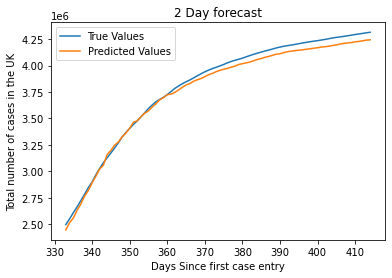

In [31]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("2 Day forecast")
plt.legend()
plt.show()

In [50]:
window_size = 7
forecast = 5
features3, labels3 = create_features(pos_cases_df, window_size, forecast)

In [51]:
training_features3, testing_features3 = np.split(features3, [int(0.8*len(features3))])
training_labels3, testing_labels3 = np.split(labels3, [int(0.8*len(labels3))])

In [52]:
history3 = NN_model.fit(training_features3, training_labels3, epochs=500, validation_split=0.2)

Train on 259 samples, validate on 65 samples
Epoch 1/500
259/259 [==============================] - 0s 121us/step - loss: 110928.1213 - accuracy: 0.0000e+00 - val_loss: 675325.1635 - val_accuracy: 0.0000e+00
Epoch 2/500
259/259 [==============================] - 0s 121us/step - loss: 65943.4317 - accuracy: 0.0000e+00 - val_loss: 194559.0808 - val_accuracy: 0.0000e+00
Epoch 3/500
259/259 [==============================] - 0s 85us/step - loss: 58270.5959 - accuracy: 0.0000e+00 - val_loss: 413003.9288 - val_accuracy: 0.0000e+00
Epoch 4/500
259/259 [==============================] - 0s 121us/step - loss: 38332.1261 - accuracy: 0.0000e+00 - val_loss: 177266.1952 - val_accuracy: 0.0000e+00
Epoch 5/500
259/259 [==============================] - 0s 121us/step - loss: 25770.1786 - accuracy: 0.0000e+00 - val_loss: 259098.7615 - val_accuracy: 0.0000e+00
Epoch 6/500
259/259 [==============================] - 0s 113us/step - loss: 22076.0712 - accuracy: 0.0000e+00 - val_loss: 211843.2615 - val_accu

259/259 [==============================] - 0s 85us/step - loss: 4482.6314 - accuracy: 0.0000e+00 - val_loss: 156238.1000 - val_accuracy: 0.0000e+00
Epoch 52/500
259/259 [==============================] - 0s 121us/step - loss: 6559.5566 - accuracy: 0.0039 - val_loss: 129161.6346 - val_accuracy: 0.0000e+00
Epoch 53/500
259/259 [==============================] - 0s 121us/step - loss: 5776.5646 - accuracy: 0.0000e+00 - val_loss: 165220.5308 - val_accuracy: 0.0000e+00
Epoch 54/500
259/259 [==============================] - 0s 60us/step - loss: 7162.5115 - accuracy: 0.0000e+00 - val_loss: 209935.1462 - val_accuracy: 0.0000e+00
Epoch 55/500
259/259 [==============================] - 0s 85us/step - loss: 4959.7998 - accuracy: 0.0000e+00 - val_loss: 165768.9038 - val_accuracy: 0.0000e+00
Epoch 56/500
259/259 [==============================] - 0s 60us/step - loss: 4079.5033 - accuracy: 0.0000e+00 - val_loss: 160426.2154 - val_accuracy: 0.0000e+00
Epoch 57/500
259/259 [===========================

259/259 [==============================] - 0s 96us/step - loss: 5983.1238 - accuracy: 0.0000e+00 - val_loss: 153781.2038 - val_accuracy: 0.0000e+00
Epoch 103/500
259/259 [==============================] - 0s 96us/step - loss: 2956.7068 - accuracy: 0.0000e+00 - val_loss: 133098.9462 - val_accuracy: 0.0000e+00
Epoch 104/500
259/259 [==============================] - 0s 100us/step - loss: 4392.6239 - accuracy: 0.0000e+00 - val_loss: 155998.3231 - val_accuracy: 0.0000e+00
Epoch 105/500
259/259 [==============================] - 0s 100us/step - loss: 3285.0876 - accuracy: 0.0000e+00 - val_loss: 181243.8615 - val_accuracy: 0.0000e+00
Epoch 106/500
259/259 [==============================] - 0s 100us/step - loss: 3309.6389 - accuracy: 0.0000e+00 - val_loss: 148011.4538 - val_accuracy: 0.0000e+00
Epoch 107/500
259/259 [==============================] - 0s 116us/step - loss: 4027.8945 - accuracy: 0.0000e+00 - val_loss: 170466.5500 - val_accuracy: 0.0000e+00
Epoch 108/500
259/259 [===============

Epoch 153/500
259/259 [==============================] - 0s 60us/step - loss: 3056.0626 - accuracy: 0.0000e+00 - val_loss: 172776.9115 - val_accuracy: 0.0000e+00
Epoch 154/500
259/259 [==============================] - 0s 121us/step - loss: 4052.0601 - accuracy: 0.0000e+00 - val_loss: 146362.7308 - val_accuracy: 0.0000e+00
Epoch 155/500
259/259 [==============================] - 0s 124us/step - loss: 3230.7760 - accuracy: 0.0039 - val_loss: 142197.5788 - val_accuracy: 0.0000e+00
Epoch 156/500
259/259 [==============================] - 0s 96us/step - loss: 2821.0582 - accuracy: 0.0000e+00 - val_loss: 121217.8240 - val_accuracy: 0.0000e+00
Epoch 157/500
259/259 [==============================] - 0s 96us/step - loss: 5729.6541 - accuracy: 0.0039 - val_loss: 132121.0019 - val_accuracy: 0.0000e+00
Epoch 158/500
259/259 [==============================] - 0s 93us/step - loss: 4664.9050 - accuracy: 0.0000e+00 - val_loss: 174765.4769 - val_accuracy: 0.0000e+00
Epoch 159/500
259/259 [===========

259/259 [==============================] - 0s 60us/step - loss: 2910.4505 - accuracy: 0.0000e+00 - val_loss: 135362.7865 - val_accuracy: 0.0000e+00
Epoch 205/500
259/259 [==============================] - 0s 85us/step - loss: 3073.1482 - accuracy: 0.0039 - val_loss: 149445.3885 - val_accuracy: 0.0000e+00
Epoch 206/500
259/259 [==============================] - 0s 60us/step - loss: 2565.7725 - accuracy: 0.0039 - val_loss: 143291.6635 - val_accuracy: 0.0000e+00
Epoch 207/500
259/259 [==============================] - 0s 121us/step - loss: 2382.6826 - accuracy: 0.0039 - val_loss: 153745.9231 - val_accuracy: 0.0000e+00
Epoch 208/500
259/259 [==============================] - 0s 60us/step - loss: 3180.8399 - accuracy: 0.0000e+00 - val_loss: 147779.6038 - val_accuracy: 0.0000e+00
Epoch 209/500
259/259 [==============================] - 0s 85us/step - loss: 2523.9954 - accuracy: 0.0039 - val_loss: 163708.4731 - val_accuracy: 0.0000e+00
Epoch 210/500
259/259 [==============================] - 

Epoch 255/500
259/259 [==============================] - 0s 93us/step - loss: 3213.6657 - accuracy: 0.0077 - val_loss: 136257.4846 - val_accuracy: 0.0000e+00
Epoch 256/500
259/259 [==============================] - 0s 93us/step - loss: 2821.9962 - accuracy: 0.0000e+00 - val_loss: 135190.0769 - val_accuracy: 0.0000e+00
Epoch 257/500
259/259 [==============================] - 0s 93us/step - loss: 2422.5946 - accuracy: 0.0039 - val_loss: 96792.0481 - val_accuracy: 0.0000e+00
Epoch 258/500
259/259 [==============================] - 0s 89us/step - loss: 6066.1571 - accuracy: 0.0077 - val_loss: 93238.5231 - val_accuracy: 0.0000e+00
Epoch 259/500
259/259 [==============================] - 0s 96us/step - loss: 4940.9693 - accuracy: 0.0000e+00 - val_loss: 118720.2538 - val_accuracy: 0.0000e+00
Epoch 260/500
259/259 [==============================] - 0s 89us/step - loss: 2997.3295 - accuracy: 0.0000e+00 - val_loss: 126663.2346 - val_accuracy: 0.0000e+00
Epoch 261/500
259/259 [===================

259/259 [==============================] - 0s 85us/step - loss: 3415.0306 - accuracy: 0.0000e+00 - val_loss: 126952.5462 - val_accuracy: 0.0000e+00
Epoch 307/500
259/259 [==============================] - 0s 121us/step - loss: 2353.0156 - accuracy: 0.0000e+00 - val_loss: 146842.5462 - val_accuracy: 0.0000e+00
Epoch 308/500
259/259 [==============================] - 0s 60us/step - loss: 4799.1460 - accuracy: 0.0077 - val_loss: 107991.5115 - val_accuracy: 0.0000e+00
Epoch 309/500
259/259 [==============================] - 0s 121us/step - loss: 7228.4215 - accuracy: 0.0039 - val_loss: 123742.0808 - val_accuracy: 0.0000e+00
Epoch 310/500
259/259 [==============================] - 0s 60us/step - loss: 5249.2277 - accuracy: 0.0039 - val_loss: 172633.3269 - val_accuracy: 0.0000e+00
Epoch 311/500
259/259 [==============================] - 0s 121us/step - loss: 4407.9257 - accuracy: 0.0039 - val_loss: 104988.0490 - val_accuracy: 0.0000e+00
Epoch 312/500
259/259 [==============================] 

259/259 [==============================] - 0s 121us/step - loss: 4111.5597 - accuracy: 0.0000e+00 - val_loss: 97403.4663 - val_accuracy: 0.0000e+00
Epoch 358/500
259/259 [==============================] - 0s 121us/step - loss: 2671.7513 - accuracy: 0.0039 - val_loss: 104572.4635 - val_accuracy: 0.0000e+00
Epoch 359/500
259/259 [==============================] - 0s 85us/step - loss: 3173.4006 - accuracy: 0.0000e+00 - val_loss: 106615.0115 - val_accuracy: 0.0000e+00
Epoch 360/500
259/259 [==============================] - 0s 121us/step - loss: 2699.0631 - accuracy: 0.0000e+00 - val_loss: 80056.4673 - val_accuracy: 0.0000e+00
Epoch 361/500
259/259 [==============================] - 0s 121us/step - loss: 5974.7208 - accuracy: 0.0000e+00 - val_loss: 102663.3673 - val_accuracy: 0.0000e+00
Epoch 362/500
259/259 [==============================] - 0s 60us/step - loss: 4432.1365 - accuracy: 0.0000e+00 - val_loss: 101974.0625 - val_accuracy: 0.0000e+00
Epoch 363/500
259/259 [=====================

259/259 [==============================] - 0s 89us/step - loss: 2397.8131 - accuracy: 0.0077 - val_loss: 142517.5231 - val_accuracy: 0.0000e+00
Epoch 409/500
259/259 [==============================] - 0s 96us/step - loss: 4153.9443 - accuracy: 0.0039 - val_loss: 112724.7038 - val_accuracy: 0.0000e+00
Epoch 410/500
259/259 [==============================] - 0s 93us/step - loss: 3522.3668 - accuracy: 0.0039 - val_loss: 146117.3154 - val_accuracy: 0.0000e+00
Epoch 411/500
259/259 [==============================] - 0s 96us/step - loss: 5352.6264 - accuracy: 0.0039 - val_loss: 156583.5000 - val_accuracy: 0.0000e+00
Epoch 412/500
259/259 [==============================] - 0s 93us/step - loss: 5017.9092 - accuracy: 0.0000e+00 - val_loss: 120030.4462 - val_accuracy: 0.0000e+00
Epoch 413/500
259/259 [==============================] - 0s 96us/step - loss: 5213.5381 - accuracy: 0.0039 - val_loss: 89934.0115 - val_accuracy: 0.0000e+00
Epoch 414/500
259/259 [==============================] - 0s 100

259/259 [==============================] - 0s 121us/step - loss: 2613.4052 - accuracy: 0.0000e+00 - val_loss: 145772.5269 - val_accuracy: 0.0000e+00
Epoch 460/500
259/259 [==============================] - 0s 104us/step - loss: 3417.0945 - accuracy: 0.0000e+00 - val_loss: 90218.0606 - val_accuracy: 0.0000e+00
Epoch 461/500
259/259 [==============================] - 0s 96us/step - loss: 3894.8658 - accuracy: 0.0039 - val_loss: 138837.3808 - val_accuracy: 0.0000e+00
Epoch 462/500
259/259 [==============================] - 0s 93us/step - loss: 5965.8905 - accuracy: 0.0000e+00 - val_loss: 134856.6712 - val_accuracy: 0.0000e+00
Epoch 463/500
259/259 [==============================] - 0s 104us/step - loss: 6292.8194 - accuracy: 0.0039 - val_loss: 88529.8788 - val_accuracy: 0.0000e+00
Epoch 464/500
259/259 [==============================] - 0s 93us/step - loss: 4100.5750 - accuracy: 0.0039 - val_loss: 123324.5558 - val_accuracy: 0.0000e+00
Epoch 465/500
259/259 [==============================

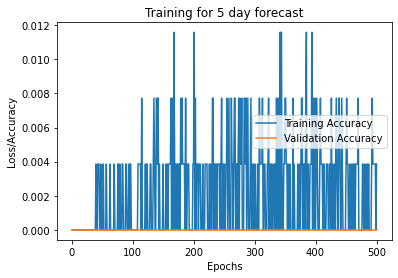

In [54]:
epochs = range(1, len(history3.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history3.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title("Training for 5 day forecast")
plt.legend()
plt.show()

In [55]:
x = [i for i in range(int(testing_features3[0,-1]+1), int(testing_features3[-1,-1]+2))]
y = testing_labels3
x_pred = testing_features3
y_pred = NN_model.predict(x_pred) 
err3 = np.abs(y - y_pred)
acc3 = np.ones(len(y)) - np.divide(err3, y)
acc_bar3 = np.mean(acc3)
rms3 = np.sqrt(np.mean((err3)**2))
print("Average accuracy:", acc_bar3)
print("RMS:", rms3)

Average accuracy: 0.835666015762657
RMS: 740631.5465441645


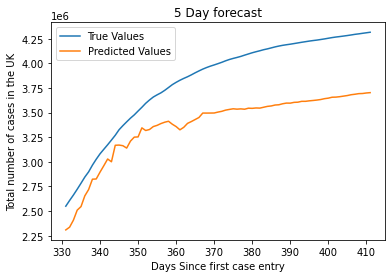

In [60]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("5 Day forecast")
plt.legend()
plt.show()

In [64]:
window_size = 7
forecast = 10
features10, labels10 = create_features(pos_cases_df, window_size, forecast)

In [65]:
training_features10, testing_features10 = np.split(features10, [int(0.8*len(features10))])
training_labels10, testing_labels10 = np.split(labels10, [int(0.8*len(labels10))])

In [66]:
history10 = NN_model.fit(training_features10, training_labels10, epochs=500, validation_split=0.2)

Train on 256 samples, validate on 64 samples
Epoch 1/500
256/256 [==============================] - 0s 105us/step - loss: 30229.8740 - accuracy: 0.0000e+00 - val_loss: 485728.3750 - val_accuracy: 0.0000e+00
Epoch 2/500
256/256 [==============================] - 0s 86us/step - loss: 19607.3739 - accuracy: 0.0000e+00 - val_loss: 270138.7422 - val_accuracy: 0.0000e+00
Epoch 3/500
256/256 [==============================] - 0s 72us/step - loss: 9734.2629 - accuracy: 0.0000e+00 - val_loss: 238959.5586 - val_accuracy: 0.0000e+00
Epoch 4/500
256/256 [==============================] - 0s 122us/step - loss: 9275.4355 - accuracy: 0.0039 - val_loss: 247901.9277 - val_accuracy: 0.0000e+00
Epoch 5/500
256/256 [==============================] - 0s 61us/step - loss: 8156.7547 - accuracy: 0.0000e+00 - val_loss: 277767.6289 - val_accuracy: 0.0000e+00
Epoch 6/500
256/256 [==============================] - 0s 122us/step - loss: 8311.5762 - accuracy: 0.0000e+00 - val_loss: 284592.5859 - val_accuracy: 0.000

Epoch 52/500
256/256 [==============================] - 0s 90us/step - loss: 4192.7766 - accuracy: 0.0000e+00 - val_loss: 242168.3438 - val_accuracy: 0.0000e+00
Epoch 53/500
256/256 [==============================] - 0s 90us/step - loss: 3500.7696 - accuracy: 0.0000e+00 - val_loss: 222135.3535 - val_accuracy: 0.0000e+00
Epoch 54/500
256/256 [==============================] - 0s 94us/step - loss: 3187.7278 - accuracy: 0.0000e+00 - val_loss: 231331.9844 - val_accuracy: 0.0000e+00
Epoch 55/500
256/256 [==============================] - 0s 90us/step - loss: 3183.4077 - accuracy: 0.0039 - val_loss: 229007.0977 - val_accuracy: 0.0000e+00
Epoch 56/500
256/256 [==============================] - 0s 90us/step - loss: 3201.5783 - accuracy: 0.0000e+00 - val_loss: 228387.4062 - val_accuracy: 0.0000e+00
Epoch 57/500
256/256 [==============================] - 0s 94us/step - loss: 2902.8861 - accuracy: 0.0000e+00 - val_loss: 231943.8672 - val_accuracy: 0.0000e+00
Epoch 58/500
256/256 [================

256/256 [==============================] - 0s 61us/step - loss: 4126.3322 - accuracy: 0.0000e+00 - val_loss: 234304.4512 - val_accuracy: 0.0000e+00
Epoch 104/500
256/256 [==============================] - 0s 122us/step - loss: 3716.0806 - accuracy: 0.0000e+00 - val_loss: 235632.9102 - val_accuracy: 0.0000e+00
Epoch 105/500
256/256 [==============================] - 0s 86us/step - loss: 3315.8190 - accuracy: 0.0039 - val_loss: 233615.9727 - val_accuracy: 0.0000e+00
Epoch 106/500
256/256 [==============================] - 0s 61us/step - loss: 3009.2934 - accuracy: 0.0000e+00 - val_loss: 235111.1875 - val_accuracy: 0.0000e+00
Epoch 107/500
256/256 [==============================] - 0s 61us/step - loss: 2865.3136 - accuracy: 0.0000e+00 - val_loss: 249543.5430 - val_accuracy: 0.0000e+00
Epoch 108/500
256/256 [==============================] - 0s 122us/step - loss: 4889.5448 - accuracy: 0.0000e+00 - val_loss: 209136.0078 - val_accuracy: 0.0000e+00
Epoch 109/500
256/256 [=====================

Epoch 154/500
256/256 [==============================] - 0s 86us/step - loss: 3440.2628 - accuracy: 0.0039 - val_loss: 239983.0605 - val_accuracy: 0.0000e+00
Epoch 155/500
256/256 [==============================] - 0s 86us/step - loss: 4738.1016 - accuracy: 0.0000e+00 - val_loss: 265997.4609 - val_accuracy: 0.0000e+00
Epoch 156/500
256/256 [==============================] - 0s 86us/step - loss: 8018.2921 - accuracy: 0.0000e+00 - val_loss: 226856.5020 - val_accuracy: 0.0000e+00
Epoch 157/500
256/256 [==============================] - 0s 86us/step - loss: 7248.4052 - accuracy: 0.0000e+00 - val_loss: 214288.1855 - val_accuracy: 0.0000e+00
Epoch 158/500
256/256 [==============================] - 0s 86us/step - loss: 4585.1659 - accuracy: 0.0000e+00 - val_loss: 236353.1797 - val_accuracy: 0.0000e+00
Epoch 159/500
256/256 [==============================] - 0s 90us/step - loss: 3278.4827 - accuracy: 0.0000e+00 - val_loss: 245842.4453 - val_accuracy: 0.0000e+00
Epoch 160/500
256/256 [=========

Epoch 205/500
256/256 [==============================] - 0s 148us/step - loss: 3253.2711 - accuracy: 0.0039 - val_loss: 242238.9258 - val_accuracy: 0.0000e+00
Epoch 206/500
256/256 [==============================] - 0s 61us/step - loss: 3218.8804 - accuracy: 0.0039 - val_loss: 235000.0312 - val_accuracy: 0.0000e+00
Epoch 207/500
256/256 [==============================] - 0s 122us/step - loss: 3149.4380 - accuracy: 0.0000e+00 - val_loss: 249630.6172 - val_accuracy: 0.0000e+00
Epoch 208/500
256/256 [==============================] - 0s 61us/step - loss: 3785.5578 - accuracy: 0.0000e+00 - val_loss: 234617.4648 - val_accuracy: 0.0000e+00
Epoch 209/500
256/256 [==============================] - 0s 148us/step - loss: 3151.4958 - accuracy: 0.0000e+00 - val_loss: 246182.9883 - val_accuracy: 0.0000e+00
Epoch 210/500
256/256 [==============================] - 0s 61us/step - loss: 3193.6176 - accuracy: 0.0000e+00 - val_loss: 239795.7207 - val_accuracy: 0.0000e+00
Epoch 211/500
256/256 [==========

Epoch 256/500
256/256 [==============================] - 0s 61us/step - loss: 2916.6106 - accuracy: 0.0000e+00 - val_loss: 233402.8125 - val_accuracy: 0.0000e+00
Epoch 257/500
256/256 [==============================] - 0s 122us/step - loss: 3201.4955 - accuracy: 0.0000e+00 - val_loss: 251238.6719 - val_accuracy: 0.0000e+00
Epoch 258/500
256/256 [==============================] - 0s 61us/step - loss: 2676.0241 - accuracy: 0.0000e+00 - val_loss: 242285.0156 - val_accuracy: 0.0000e+00
Epoch 259/500
256/256 [==============================] - 0s 86us/step - loss: 3659.1224 - accuracy: 0.0039 - val_loss: 261944.7031 - val_accuracy: 0.0000e+00
Epoch 260/500
256/256 [==============================] - 0s 61us/step - loss: 3571.8162 - accuracy: 0.0000e+00 - val_loss: 242620.0859 - val_accuracy: 0.0000e+00
Epoch 261/500
256/256 [==============================] - 0s 122us/step - loss: 2242.2245 - accuracy: 0.0039 - val_loss: 245471.0449 - val_accuracy: 0.0000e+00
Epoch 262/500
256/256 [===========

Epoch 307/500
256/256 [==============================] - 0s 86us/step - loss: 3391.0103 - accuracy: 0.0000e+00 - val_loss: 260702.9238 - val_accuracy: 0.0000e+00
Epoch 308/500
256/256 [==============================] - 0s 86us/step - loss: 3415.5711 - accuracy: 0.0000e+00 - val_loss: 250957.1406 - val_accuracy: 0.0000e+00
Epoch 309/500
256/256 [==============================] - 0s 86us/step - loss: 3070.7140 - accuracy: 0.0000e+00 - val_loss: 235542.2383 - val_accuracy: 0.0000e+00
Epoch 310/500
256/256 [==============================] - 0s 94us/step - loss: 2799.8852 - accuracy: 0.0000e+00 - val_loss: 263533.0586 - val_accuracy: 0.0000e+00
Epoch 311/500
256/256 [==============================] - 0s 94us/step - loss: 3406.6800 - accuracy: 0.0000e+00 - val_loss: 244032.0234 - val_accuracy: 0.0000e+00
Epoch 312/500
256/256 [==============================] - 0s 86us/step - loss: 2799.0752 - accuracy: 0.0039 - val_loss: 253476.4551 - val_accuracy: 0.0000e+00
Epoch 313/500
256/256 [=========

Epoch 358/500
256/256 [==============================] - 0s 86us/step - loss: 2450.5862 - accuracy: 0.0000e+00 - val_loss: 256410.4609 - val_accuracy: 0.0000e+00
Epoch 359/500
256/256 [==============================] - 0s 61us/step - loss: 2557.0887 - accuracy: 0.0000e+00 - val_loss: 256983.8047 - val_accuracy: 0.0000e+00
Epoch 360/500
256/256 [==============================] - 0s 122us/step - loss: 2599.4614 - accuracy: 0.0000e+00 - val_loss: 251821.6133 - val_accuracy: 0.0000e+00
Epoch 361/500
256/256 [==============================] - 0s 61us/step - loss: 3673.8009 - accuracy: 0.0000e+00 - val_loss: 272727.6133 - val_accuracy: 0.0000e+00
Epoch 362/500
256/256 [==============================] - 0s 86us/step - loss: 2864.4727 - accuracy: 0.0000e+00 - val_loss: 254289.2539 - val_accuracy: 0.0000e+00
Epoch 363/500
256/256 [==============================] - 0s 61us/step - loss: 2767.7599 - accuracy: 0.0039 - val_loss: 260345.4180 - val_accuracy: 0.0000e+00
Epoch 364/500
256/256 [========

Epoch 409/500
256/256 [==============================] - 0s 90us/step - loss: 2863.7676 - accuracy: 0.0000e+00 - val_loss: 265221.1016 - val_accuracy: 0.0000e+00
Epoch 410/500
256/256 [==============================] - 0s 68us/step - loss: 2188.4720 - accuracy: 0.0039 - val_loss: 267456.9844 - val_accuracy: 0.0000e+00
Epoch 411/500
256/256 [==============================] - 0s 116us/step - loss: 2408.2952 - accuracy: 0.0039 - val_loss: 268140.6758 - val_accuracy: 0.0000e+00
Epoch 412/500
256/256 [==============================] - 0s 61us/step - loss: 2493.8225 - accuracy: 0.0039 - val_loss: 265887.0664 - val_accuracy: 0.0000e+00
Epoch 413/500
256/256 [==============================] - 0s 122us/step - loss: 2300.6301 - accuracy: 0.0000e+00 - val_loss: 250670.0273 - val_accuracy: 0.0000e+00
Epoch 414/500
256/256 [==============================] - 0s 61us/step - loss: 2719.0686 - accuracy: 0.0039 - val_loss: 267483.1113 - val_accuracy: 0.0000e+00
Epoch 415/500
256/256 [===================

Epoch 460/500
256/256 [==============================] - 0s 86us/step - loss: 2777.4268 - accuracy: 0.0000e+00 - val_loss: 250666.5156 - val_accuracy: 0.0000e+00
Epoch 461/500
256/256 [==============================] - 0s 86us/step - loss: 3178.2207 - accuracy: 0.0000e+00 - val_loss: 270268.0352 - val_accuracy: 0.0000e+00
Epoch 462/500
256/256 [==============================] - 0s 90us/step - loss: 2954.4995 - accuracy: 0.0039 - val_loss: 253253.0039 - val_accuracy: 0.0000e+00
Epoch 463/500
256/256 [==============================] - 0s 86us/step - loss: 3211.9346 - accuracy: 0.0000e+00 - val_loss: 260758.4355 - val_accuracy: 0.0000e+00
Epoch 464/500
256/256 [==============================] - 0s 86us/step - loss: 2796.3945 - accuracy: 0.0000e+00 - val_loss: 259213.1602 - val_accuracy: 0.0000e+00
Epoch 465/500
256/256 [==============================] - 0s 94us/step - loss: 3175.3504 - accuracy: 0.0000e+00 - val_loss: 270317.1406 - val_accuracy: 0.0000e+00
Epoch 466/500
256/256 [=========

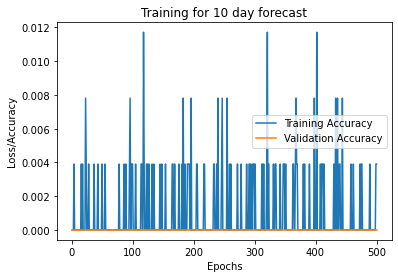

In [67]:
epochs = range(1, len(history10.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history10.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history10.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title("Training for 10 day forecast")
plt.legend()
plt.show()

In [68]:
x = [i for i in range(int(testing_features10[0,-1]+1), int(testing_features10[-1,-1]+2))]
y = testing_labels10
x_pred = testing_features10
y_pred = NN_model.predict(x_pred) 
err10 = np.abs(y - y_pred)
acc10 = np.ones(len(y)) - np.divide(err10, y)
acc_bar10 = np.mean(acc10)
rms10 = np.sqrt(np.mean((err10)**2))
print("Average accuracy:", acc_bar10)
print("RMS:", rms10)

Average accuracy: 0.8054245147949846
RMS: 887435.4899409855


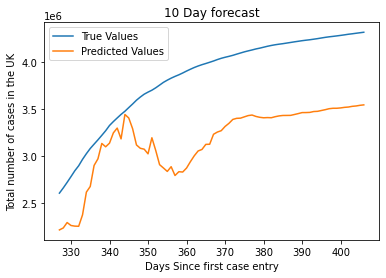

In [69]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("10 Day forecast")
plt.legend()
plt.show()

In [44]:
window_size = 7
forecast = 50
features50, labels50 = create_features(pos_cases_df, window_size, forecast)

In [45]:
training_features50, testing_features50 = np.split(features50, [int(0.8*len(features50))])
training_labels50, testing_labels50 = np.split(labels50, [int(0.8*len(labels50))])

In [46]:
history50 = NN_model.fit(training_features50, training_labels50, epochs=500, validation_split=0.2)

Train on 230 samples, validate on 58 samples
Epoch 1/500
230/230 [==============================] - 0s 164us/step - loss: 130293.8096 - accuracy: 0.0000e+00 - val_loss: 494120.6562 - val_accuracy: 0.0000e+00
Epoch 2/500
230/230 [==============================] - 0s 68us/step - loss: 119558.8473 - accuracy: 0.0000e+00 - val_loss: 517587.8427 - val_accuracy: 0.0000e+00
Epoch 3/500
230/230 [==============================] - 0s 136us/step - loss: 113191.4832 - accuracy: 0.0000e+00 - val_loss: 597538.0496 - val_accuracy: 0.0000e+00
Epoch 4/500
230/230 [==============================] - 0s 136us/step - loss: 108442.1793 - accuracy: 0.0000e+00 - val_loss: 605988.4009 - val_accuracy: 0.0000e+00
Epoch 5/500
230/230 [==============================] - 0s 96us/step - loss: 108818.0582 - accuracy: 0.0000e+00 - val_loss: 644593.7565 - val_accuracy: 0.0000e+00
Epoch 6/500
230/230 [==============================] - 0s 68us/step - loss: 107351.5853 - accuracy: 0.0000e+00 - val_loss: 591814.4332 - val_a

Epoch 51/500
230/230 [==============================] - 0s 100us/step - loss: 59093.6369 - accuracy: 0.0000e+00 - val_loss: 663332.9030 - val_accuracy: 0.0000e+00
Epoch 52/500
230/230 [==============================] - 0s 91us/step - loss: 59239.6677 - accuracy: 0.0000e+00 - val_loss: 648320.6918 - val_accuracy: 0.0000e+00
Epoch 53/500
230/230 [==============================] - 0s 96us/step - loss: 59164.1993 - accuracy: 0.0000e+00 - val_loss: 539579.6164 - val_accuracy: 0.0000e+00
Epoch 54/500
230/230 [==============================] - 0s 96us/step - loss: 55157.8009 - accuracy: 0.0000e+00 - val_loss: 652482.0560 - val_accuracy: 0.0000e+00
Epoch 55/500
230/230 [==============================] - 0s 29us/step - loss: 50967.8558 - accuracy: 0.0000e+00 - val_loss: 617408.2134 - val_accuracy: 0.0000e+00
Epoch 56/500
230/230 [==============================] - 0s 68us/step - loss: 51005.5815 - accuracy: 0.0000e+00 - val_loss: 627368.7651 - val_accuracy: 0.0000e+00
Epoch 57/500
230/230 [=====

230/230 [==============================] - 0s 96us/step - loss: 39253.2173 - accuracy: 0.0000e+00 - val_loss: 703891.5302 - val_accuracy: 0.0000e+00
Epoch 102/500
230/230 [==============================] - 0s 100us/step - loss: 36105.6687 - accuracy: 0.0000e+00 - val_loss: 751745.1789 - val_accuracy: 0.0000e+00
Epoch 103/500
230/230 [==============================] - 0s 100us/step - loss: 37513.1504 - accuracy: 0.0000e+00 - val_loss: 684803.5194 - val_accuracy: 0.0000e+00
Epoch 104/500
230/230 [==============================] - 0s 96us/step - loss: 35344.1441 - accuracy: 0.0000e+00 - val_loss: 707082.3125 - val_accuracy: 0.0000e+00
Epoch 105/500
230/230 [==============================] - 0s 96us/step - loss: 38506.1284 - accuracy: 0.0000e+00 - val_loss: 707730.7996 - val_accuracy: 0.0000e+00
Epoch 106/500
230/230 [==============================] - 0s 96us/step - loss: 36065.0909 - accuracy: 0.0000e+00 - val_loss: 710866.1810 - val_accuracy: 0.0000e+00
Epoch 107/500
230/230 [===========

230/230 [==============================] - 0s 136us/step - loss: 42515.2975 - accuracy: 0.0000e+00 - val_loss: 682262.6918 - val_accuracy: 0.0000e+00
Epoch 152/500
230/230 [==============================] - 0s 96us/step - loss: 37738.1440 - accuracy: 0.0000e+00 - val_loss: 576784.6595 - val_accuracy: 0.0000e+00
Epoch 153/500
230/230 [==============================] - 0s 68us/step - loss: 55770.2378 - accuracy: 0.0000e+00 - val_loss: 888224.3362 - val_accuracy: 0.0000e+00
Epoch 154/500
230/230 [==============================] - 0s 136us/step - loss: 49878.1074 - accuracy: 0.0000e+00 - val_loss: 594906.9030 - val_accuracy: 0.0000e+00
Epoch 155/500
230/230 [==============================] - 0s 68us/step - loss: 37363.6431 - accuracy: 0.0000e+00 - val_loss: 845776.2004 - val_accuracy: 0.0000e+00
Epoch 156/500
230/230 [==============================] - 0s 136us/step - loss: 33503.6580 - accuracy: 0.0000e+00 - val_loss: 709338.4892 - val_accuracy: 0.0000e+00
Epoch 157/500
230/230 [==========

230/230 [==============================] - 0s 68us/step - loss: 27575.4325 - accuracy: 0.0000e+00 - val_loss: 743887.4483 - val_accuracy: 0.0000e+00
Epoch 202/500
230/230 [==============================] - 0s 136us/step - loss: 30974.1742 - accuracy: 0.0000e+00 - val_loss: 646944.9763 - val_accuracy: 0.0000e+00
Epoch 203/500
230/230 [==============================] - 0s 96us/step - loss: 29065.2792 - accuracy: 0.0000e+00 - val_loss: 710534.5797 - val_accuracy: 0.0000e+00
Epoch 204/500
230/230 [==============================] - 0s 68us/step - loss: 29831.8449 - accuracy: 0.0000e+00 - val_loss: 707685.4935 - val_accuracy: 0.0000e+00
Epoch 205/500
230/230 [==============================] - 0s 68us/step - loss: 30225.2025 - accuracy: 0.0000e+00 - val_loss: 795123.9310 - val_accuracy: 0.0000e+00
Epoch 206/500
230/230 [==============================] - 0s 68us/step - loss: 29771.3311 - accuracy: 0.0000e+00 - val_loss: 739777.2069 - val_accuracy: 0.0000e+00
Epoch 207/500
230/230 [============

230/230 [==============================] - 0s 136us/step - loss: 28993.2483 - accuracy: 0.0000e+00 - val_loss: 792760.5582 - val_accuracy: 0.0000e+00
Epoch 252/500
230/230 [==============================] - 0s 68us/step - loss: 26142.5099 - accuracy: 0.0000e+00 - val_loss: 800164.0086 - val_accuracy: 0.0000e+00
Epoch 253/500
230/230 [==============================] - 0s 136us/step - loss: 28898.4174 - accuracy: 0.0000e+00 - val_loss: 797316.4957 - val_accuracy: 0.0000e+00
Epoch 254/500
230/230 [==============================] - 0s 96us/step - loss: 24597.8996 - accuracy: 0.0000e+00 - val_loss: 788082.0905 - val_accuracy: 0.0000e+00
Epoch 255/500
230/230 [==============================] - 0s 68us/step - loss: 28215.1933 - accuracy: 0.0000e+00 - val_loss: 749873.4547 - val_accuracy: 0.0000e+00
Epoch 256/500
230/230 [==============================] - 0s 136us/step - loss: 27038.7144 - accuracy: 0.0000e+00 - val_loss: 728822.9935 - val_accuracy: 0.0000e+00
Epoch 257/500
230/230 [==========

230/230 [==============================] - 0s 96us/step - loss: 18955.3616 - accuracy: 0.0000e+00 - val_loss: 793653.3319 - val_accuracy: 0.0000e+00
Epoch 302/500
230/230 [==============================] - 0s 96us/step - loss: 21690.2018 - accuracy: 0.0000e+00 - val_loss: 796284.1853 - val_accuracy: 0.0000e+00
Epoch 303/500
230/230 [==============================] - 0s 96us/step - loss: 28496.0482 - accuracy: 0.0000e+00 - val_loss: 822463.2371 - val_accuracy: 0.0000e+00
Epoch 304/500
230/230 [==============================] - 0s 91us/step - loss: 23687.7220 - accuracy: 0.0000e+00 - val_loss: 761622.1444 - val_accuracy: 0.0000e+00
Epoch 305/500
230/230 [==============================] - 0s 96us/step - loss: 22153.5889 - accuracy: 0.0000e+00 - val_loss: 795810.5991 - val_accuracy: 0.0000e+00
Epoch 306/500
230/230 [==============================] - 0s 96us/step - loss: 19144.8201 - accuracy: 0.0000e+00 - val_loss: 745946.3858 - val_accuracy: 0.0000e+00
Epoch 307/500
230/230 [=============

230/230 [==============================] - 0s 110us/step - loss: 16509.7590 - accuracy: 0.0000e+00 - val_loss: 774518.5797 - val_accuracy: 0.0000e+00
Epoch 352/500
230/230 [==============================] - 0s 96us/step - loss: 15706.2038 - accuracy: 0.0000e+00 - val_loss: 765173.3836 - val_accuracy: 0.0000e+00
Epoch 353/500
230/230 [==============================] - 0s 100us/step - loss: 15674.5761 - accuracy: 0.0000e+00 - val_loss: 759118.6336 - val_accuracy: 0.0000e+00
Epoch 354/500
230/230 [==============================] - 0s 96us/step - loss: 15287.2795 - accuracy: 0.0000e+00 - val_loss: 786608.3707 - val_accuracy: 0.0000e+00
Epoch 355/500
230/230 [==============================] - 0s 96us/step - loss: 17322.5046 - accuracy: 0.0000e+00 - val_loss: 809847.9698 - val_accuracy: 0.0000e+00
Epoch 356/500
230/230 [==============================] - 0s 100us/step - loss: 16319.1635 - accuracy: 0.0000e+00 - val_loss: 825694.3556 - val_accuracy: 0.0000e+00
Epoch 357/500
230/230 [==========

230/230 [==============================] - 0s 136us/step - loss: 14090.5189 - accuracy: 0.0000e+00 - val_loss: 780806.8621 - val_accuracy: 0.0000e+00
Epoch 402/500
230/230 [==============================] - 0s 96us/step - loss: 13539.1808 - accuracy: 0.0000e+00 - val_loss: 797084.4030 - val_accuracy: 0.0000e+00
Epoch 403/500
230/230 [==============================] - 0s 68us/step - loss: 12275.6799 - accuracy: 0.0000e+00 - val_loss: 785474.9763 - val_accuracy: 0.0000e+00
Epoch 404/500
230/230 [==============================] - 0s 136us/step - loss: 12929.2287 - accuracy: 0.0000e+00 - val_loss: 782279.8901 - val_accuracy: 0.0000e+00
Epoch 405/500
230/230 [==============================] - 0s 68us/step - loss: 12014.3734 - accuracy: 0.0000e+00 - val_loss: 796316.6164 - val_accuracy: 0.0000e+00
Epoch 406/500
230/230 [==============================] - 0s 96us/step - loss: 17301.5100 - accuracy: 0.0000e+00 - val_loss: 862219.3039 - val_accuracy: 0.0000e+00
Epoch 407/500
230/230 [===========

230/230 [==============================] - 0s 96us/step - loss: 16872.2633 - accuracy: 0.0000e+00 - val_loss: 808007.0086 - val_accuracy: 0.0000e+00
Epoch 452/500
230/230 [==============================] - 0s 100us/step - loss: 21857.6094 - accuracy: 0.0000e+00 - val_loss: 796398.7565 - val_accuracy: 0.0000e+00
Epoch 453/500
230/230 [==============================] - 0s 104us/step - loss: 20317.1721 - accuracy: 0.0000e+00 - val_loss: 819755.3858 - val_accuracy: 0.0000e+00
Epoch 454/500
230/230 [==============================] - 0s 96us/step - loss: 14915.3159 - accuracy: 0.0000e+00 - val_loss: 787213.8901 - val_accuracy: 0.0000e+00
Epoch 455/500
230/230 [==============================] - 0s 100us/step - loss: 16235.8751 - accuracy: 0.0000e+00 - val_loss: 814930.0776 - val_accuracy: 0.0000e+00
Epoch 456/500
230/230 [==============================] - 0s 96us/step - loss: 12981.3608 - accuracy: 0.0000e+00 - val_loss: 790404.1983 - val_accuracy: 0.0000e+00
Epoch 457/500
230/230 [==========

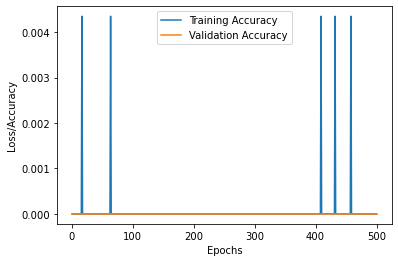

In [47]:
epochs = range(1, len(history50.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history50.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history50.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [48]:
x = [i for i in range(int(testing_features50[0,-1]+1), int(testing_features50[-1,-1]+2))]
y = testing_labels50
x_pred = testing_features50
y_pred = NN_model.predict(x_pred) 
err50 = np.abs(y - y_pred)
acc50 = np.ones(len(y)) - np.divide(err50, y)
acc_bar50 = np.mean(acc50)
rms50 = np.sqrt(np.mean((err50)**2))
print("Average accuracy:", acc_bar50)
print("RMS:", rms50)

Average accuracy: 0.6372908913119955
RMS: 1677559.618808206


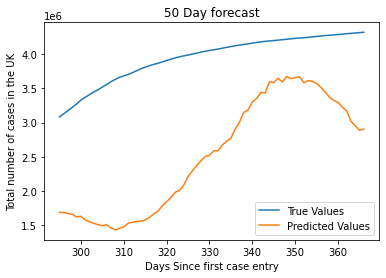

In [49]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("50 Day forecast")
plt.legend()
plt.show()